<a href="https://colab.research.google.com/github/gabiamorim2/projeto_ebac_loggi/blob/main/1%C2%BA_Projeto_EBAC_An%C3%A1lise_Explorat%C3%B3ria_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1º Projeto EBAC - Análise Exploratória de Dados de Logística**

**Problema de Negócio - Loggi.**

A Loggi é um serviço brasileiro de logística que usa tecnologia para entregas mais eficientes de pacotes para todo Brasil e está presente em todas as capitais do país. Dispõem do apoio de dezenas de agências e nove centros de distribuição próprios, além de mais de 400 transportadoras parceiras. A problemática é muito parecida com outras empresas de lógística, a otimização das rotas de entrega, alocação de entregas/pacotes nos veículos das frotas com capacidade limitada, posicionamento dos *hubs* (centros regionais) de consolidação em toda cidade, divisão das demandas igualmente em veículos de entrega. Esse desafios são enfrentados dia-a-dia e potencializados por sua larga escala. Presente neste projeto, estão as análises referentes as entregas realizadas no Distrito Federal.

*Referências:*

https://www.loggi.com/conheca-a-loggi/

https://github.com/loggi/loggibud

https://www.ibge.gov.br/


**1. Bibliotecas e Pacotes**

In [ ]:
#instalando o pacote geopandas para visualização de coordenadas geográficas

!pip install geopandas

     |████████████████████████████████| 1.0 MB 22.7 MB/s 
     |████████████████████████████████| 6.3 MB 50.7 MB/s 
     |████████████████████████████████| 16.7 MB 42.8 MB/s 


In [ ]:
#importando as bibliotecas para manipulação, geocodificação e visualização dos dados

import json
import pandas as pd
import numpy as np
import geopandas
import geopy

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import matplotlib.pyplot as plt
import seaborn as sns

**2. Coleta de dados**

*   **Download** dos dados e mapas:

**2.1** Download dos **dados brutos** do tipo **JSON** com a lista da instância de entregas:

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json 

**2.2** Como as entregas somam um total de **634.149**, levaria em torno de 7 dias para consulta no servidor **Nominatim**, dadas restrições do próprio servidor, portando faremos o dowload das entregas no link abaixo:

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv 

**2.3** Download dos **mapas** do Distrito Federal, feitos a partir do site oficial do **IBGE**:

In [ ]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

**2.4** Os dados brutos estão em um arquivo do tipo **Json**, onde:

*   **name:** é um nome único de uma instância (*string/object*);
*   **region:** nome único da região onde o hub está localizado (*string/object*);
*   **origin:** um dicionário com latitude e longitude da região do hub (*dict*);
*   **vehicle_capacity:** soma da capacidade de carga dos veículos do hub (*int*);
*   **deliveries:** uma lista de dicionários com as entregas que devem ser realizadas (*list* e *dict*);
*   **id:** número único da entrega (*string/object*);
*   **point:** um dicionário com a latitude e longitude da entrega (*dict*);
*   **size:** um número inteiro com o tamanho/carga que a entrega ocupa no veículo (*int*).



In [ ]:
#salvando os dados do arquivo em um dicionário Python

with open('deliveries.json', mode='r', encoding='utf8') as file:
  dados = json.load(file)

In [ ]:
len(dados)

199

In [ ]:
#explorando as informações das instâncias para confirmar que a etapa foi bem sucetida

teste = dados[0]

In [ ]:
#imprimindo as chaves

print(teste.keys())

dict_keys(['name', 'region', 'origin', 'vehicle_capacity', 'deliveries'])


In [ ]:
teste['name']

'cvrp-2-df-33'

In [ ]:
teste['region']

'df-2'

In [ ]:
teste['origin']

{'lat': -15.83814451122274, 'lng': -48.05498915846707}

In [ ]:
teste['origin']['lng']

-48.05498915846707

In [ ]:
teste['origin']['lat']

-15.83814451122274

In [ ]:
teste['vehicle_capacity']

180

**3. Data Wrangling**

In [ ]:
#transformando os dados em um dataframe para manipulação

loggi_df = pd.DataFrame(dados)

In [ ]:
loggi_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [ ]:
#normalizando a coluna origin com a operação flatten (ou achatamento) que transforma cada chave json em uma nova coluna

origin_df = pd.json_normalize(loggi_df['origin'])
origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


In [ ]:
#com os dados da coluna origin normalizados, vamos junta-los aos dados principais

loggi_df = pd.merge(left=loggi_df, right=origin_df, how='inner', left_index=True, right_index=True)
loggi_df.head()

,name,region,origin,vehicle_capacity,deliveries,lng,lat
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p...",-47.893662,-15.805118
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p...",-48.054989,-15.838145


In [ ]:
#vamos remover a coluna origin

loggi_df = loggi_df.drop('origin', axis=1)
loggi_df = loggi_df[['name', 'region', 'lng', 'lat', 'vehicle_capacity', 'deliveries']]
loggi_df.head()

,name,region,lng,lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [ ]:
#renomeando as colunas lng e lat

loggi_df.rename(columns={'lng':'hub_lng', 'lat':'hub_lat'}, inplace=True)
loggi_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [ ]:
#para normalizar a coluna deliveries, que possui uma lista de dados aninhados, usamos a operação explode, que transforma cada elemento da lista 
#em uma linha. Depois finalizamos com o achatamento (flatten)

deliveries_exploded_df = loggi_df[['deliveries']].explode('deliveries')
deliveries_exploded_df.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


In [ ]:
#agora criamos um dataframe para cada coluna de interesse e depois concatenamos os dataframes verticalmente para manter as informações corretas
#preservando os indices. A coluna ID é deixada de fora pois não é relevante para as análises desse projeto

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['size'])).rename(columns={'deliveries':'delivery_size'}),
  pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['point']['lng'])).rename(columns={'deliveries':'delivery_lng'}),
  pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['point']['lat'])).rename(columns={'deliveries':'delivery_lat'}),
  ], axis=1)

deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


In [ ]:
len(deliveries_exploded_df)

636149

In [ ]:
#construindo o dataframe final com todas as informações trabalhadas

loggi_df = loggi_df.drop('deliveries', axis=1)
loggi_df = pd.merge(left=loggi_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
loggi_df.reset_index(inplace=True, drop=True)

loggi_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


**4. Geocodificação**

A Geocodificação é um processo que transforma uma *localização descrita por texto* (endereço, nome do local, nome da rua/bairro, etc) em sua respectiva *coordenada geográfica* (latitude/longitude). A Geocodificação *reversa* faz o oposto, transformando uma coordenada geográfica de um local em sua respectiva  descrição textual. Vamos aplicar a Geocodificação neste projeto para uma melhor visualização das entregas e da localização dos hubs.

In [ ]:
#construindo um dataframe só com as informações de coordenadas especificas dos hubs, tirando todas as informações duplicadas
#só temos 3 regiões com coordenadas únicas

hub_df = loggi_df[['region', 'hub_lng', 'hub_lat']]
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


*   Utilizando um serviço gratuito de geocodificação chamado **Nominatim**, fornecido por um projeto open source chamado **OpenStreetMap**, vamos aplicar a geocodificação através do pacote python **Geopy**

In [ ]:
#vamos aplicar a geocodificação nas coordenadas das 3 regiões e extrair informações sobre a cidade e o bairro

geolocator = Nominatim(user_agent='ebac_geocoder')
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds = 1)

In [ ]:
#vamos criar mais uma coluna no dataframe dos hubs com as coordenadas em formato de string e depois mais uma coluna aplicando a função geocoder

hub_df['coordinates'] = hub_df['hub_lat'].astype(str) + ',' + hub_df['hub_lng'].astype(str)
hub_df['geodata'] = hub_df['coordinates'].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248,-47.802664728268745","(Clinica dos Olhos, Rua 7, Quadra 2, Sobradinh..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334,-47.89366206897872","(Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíl..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274,-48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [ ]:
#para normalizar as informações da coluna geodata, vamos criar um novo dataframe com o método normalize

hub_geodata_df = pd.json_normalize(hub_df['geodata'].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,display_name,boundingbox,address.amenity,address.road,...,address.state,address.region,address.postcode,address.country,address.country_code,address.building,address.neighbourhood,address.city,address.shop,address.house_number
0,69392732,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6456379935,-15.656819,-47.8019514,"Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho...","[-15.656869, -15.656769, -47.8020014, -47.8019...",Clinica dos Olhos,Rua 7,...,Distrito Federal,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN,NaN
1,134245547,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,140908717,-15.80443735,-47.893155456691616,"Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíli...","[-15.805071, -15.8038038, -47.8937468, -47.892...",NaN,W1 Sul,...,Distrito Federal,Região Centro-Oeste,70342-010,Brasil,br,Bloco B / F,SQS 103,Brasília,NaN,NaN
2,68616994,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,"Armazém do Bolo, lote 4/8, CSB 4/5, Taguatinga...","[-15.8384871, -15.8383871, -48.0553417, -48.05...",NaN,CSB 4/5,...,Distrito Federal,Região Centro-Oeste,72015030,Brasil,br,NaN,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [ ]:
#vamos selecionar as colunas de interesse e manipular/limpar as informações

hub_geodata_df = hub_geodata_df[['address.town', 'address.suburb', 'address.city']]
hub_geodata_df.rename(columns={'address.town':'hub_town', 'address.suburb':'hub_suburb', 'address.city':'hub_city'}, inplace=True)
hub_geodata_df['hub_city'] = np.where(hub_geodata_df['hub_city'].notna(), hub_geodata_df['hub_city'], hub_geodata_df['hub_town'])
hub_geodata_df['hub_suburb'] = np.where(hub_geodata_df['hub_suburb'].notna(), hub_geodata_df['hub_suburb'], hub_geodata_df['hub_city'])
hub_geodata_df = hub_geodata_df.drop('hub_town', axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [ ]:
#agora vamos combinar as informações do dataframe hub_geodata_df com o dataframe hub_df e por fim juntá-los com o dataframe loggi_df

hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[['region', 'hub_suburb', 'hub_city']]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [ ]:
loggi_df = pd.merge(left=loggi_df, right=hub_df, how='inner', on='region')
loggi_df = loggi_df[['name', 'region', 'hub_lng', 'hub_lat', 'hub_suburb', 
                               'hub_city', 'vehicle_capacity', 'delivery_size', 'delivery_lng', 'delivery_lat']]
loggi_df.head()

,name,region,hub_lng,hub_lat,hub_suburb,hub_city,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


*   Vamos aplicar a geocodificação das **634.149 entregas**, salvando as informações do download em um dataframe:

In [ ]:
deliveries_geodata_df = pd.read_csv('deliveries-geodata.csv')
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
#construindo o dataframe final enriquecido com a geocodificação

loggi_df = pd.merge(left=loggi_df, right=deliveries_geodata_df[['delivery_city', 'delivery_suburb']], how='inner', left_index=True, right_index=True)
loggi_df.head()

,name,region,hub_lng,hub_lat,hub_suburb,hub_city,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


**5. Estrutura**

In [ ]:
#explorando as estruturas do dataframe criado

linhas, colunas = loggi_df.shape

In [ ]:
print(linhas)

636149


In [ ]:
print(colunas)

12


In [ ]:
#colunas

loggi_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'hub_suburb', 'hub_city',
       'vehicle_capacity', 'delivery_size', 'delivery_lng', 'delivery_lat',
       'delivery_city', 'delivery_suburb'],
      dtype='object')

In [ ]:
#conferindo todas as informações referentes ao dataframe

loggi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_suburb        636149 non-null  object 
 5   hub_city          636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 79.2+ MB


**6. Schema**

Etapa de verficação, vamos conferir se as colunas são consistentes com seus tipos de dados.

In [ ]:
loggi_df.dtypes

name                 object
region               object
hub_lng             float64
hub_lat             float64
hub_suburb           object
hub_city             object
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
delivery_city        object
delivery_suburb      object
dtype: object

Analisando os atributos **categóricos**:

In [ ]:
#selecionando apenas as colunas com tipo de dado object

loggi_df.select_dtypes('object').describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708
hub_suburb,636149,3,Asa Sul,304708
hub_city,636149,3,Brasília,304708
delivery_city,634447,38,Brasília,148983
delivery_suburb,476264,167,Brasília,53795


In [ ]:
#extraindo todos os valores de região (region) que existem no dataframe

loggi_df.region.unique()

array(['df-2', 'df-1', 'df-0'], dtype=object)

*   Existem 199 instâncias (**name**), e a instância "*cvrp-1-df-87*" é a que aparece com maior **frequência** (5.636);
*   Existem 3 regiões (**region**) df-0, df-1, df-2 e a região *df-1* é a que aparece com maior **frequência** (304.708).
*   O bairro do hub (**hub_suburb**) Asa Sul é o que aparece com maior frequência de entregas.

Analisando os atributos **numéricos**:

In [ ]:
#primeiro excluimos as colunas categóricas e selecionamos as colunas com os dados inteiros

loggi_df.drop(['name', 'region'], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


*   A **média** (*mean*) da capacidade de carga dos veículos é 180.0 e o **desvio padrão** (*std*) é 0, o que significa que a capacidade de entrega de cada uma das regiões é a **mesma**.

*   O tamanho da entrega (*delivery_size*) possui **média** de 5.5 e **desvio padrão** de 2.8, sendo a entrega **mínima** de 1 pacote e entrega **máxima** de 10 pacotes.

**7. Qualidade dos dados**

Vamos verificar se existe algum dado nulo ou faltante nas informações e se eles impactam de alguma forma os insights deste projeto.

In [ ]:
#esse método verifica e existe algum tipo de dado faltante ou nulo no dataframe (dados vazios, não numpericos, não disponíveis, etc)

loggi_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_suburb          False
hub_city            False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

*   De acordo com a análise acima, existem dados nulos na coluna **'delivery_city'** e na coluna **'delivery_suburb'**. Vamos contabilizar esses dados em forma de porcentagem para entender se eles impactam de alguma forma os resultados.

In [ ]:
#conferindo a porcentagem de valores nulos na coluna delivery_city

100 * (loggi_df['delivery_city'].isna().sum() / len(loggi_df))

0.26754738276724477

In [ ]:
#conferindo a porcentagem de valores nulos na coluna delivery_suburb

100 * (loggi_df['delivery_suburb'].isna().sum() / len(loggi_df))

25.133262804783158

In [ ]:
#contagem de valores nulos por cidade

cont_df = loggi_df[['delivery_city']].value_counts() / len(loggi_df)
cont_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
dtype: float64

In [ ]:
#contagem de valores nulos por bairro

cont2_df = loggi_df[['delivery_suburb']].value_counts() / len(loggi_df)
cont2_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
dtype: float64

De acordo com as análises acima, vimos que o percentual de dados nulos para coluna **delivery_city** é de 0.26% e para coluna **delivery_suburb** é de 25%. Observando a contagem de valores nulos por cidade/bairro, vemos que é um valor muito baixo em relação ao total, portanto não há necessidade de retirar ou tratar esses dados de nenhuma forma, pois estes valores não influenciaram a visualização final proposta por este projeto.

**8. Visualização e Insights**

**8.1 Mapa de entregas por região**. Vamos utilizar o pacote **GeoPandas** para visualização das coordenadas dos *hubs* e das entregas no mapa do Distrito Federal, segmentados pelas regiões dos *hubs*.

In [ ]:
#carregando o mapa do Distrito Federal

mapa = geopandas.read_file('distrito-federal.shp')
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


*   **Mapa dos *hubs***

In [ ]:
#vamos criar um dataframe com os pontos geográficos dos hubs, a coluna geometry é a combinação da longitude e latitude

hub_df = loggi_df[['region', 'hub_lng', 'hub_lat']].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df['hub_lng'], hub_df['hub_lat']))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


*   **Mapa das *entregas***

In [ ]:
geo_deliveries_df = geopandas.GeoDataFrame(loggi_df, geometry=geopandas.points_from_xy(loggi_df['delivery_lng'], loggi_df['delivery_lat']))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_suburb,hub_city,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


*   **Visualização do mapa** 

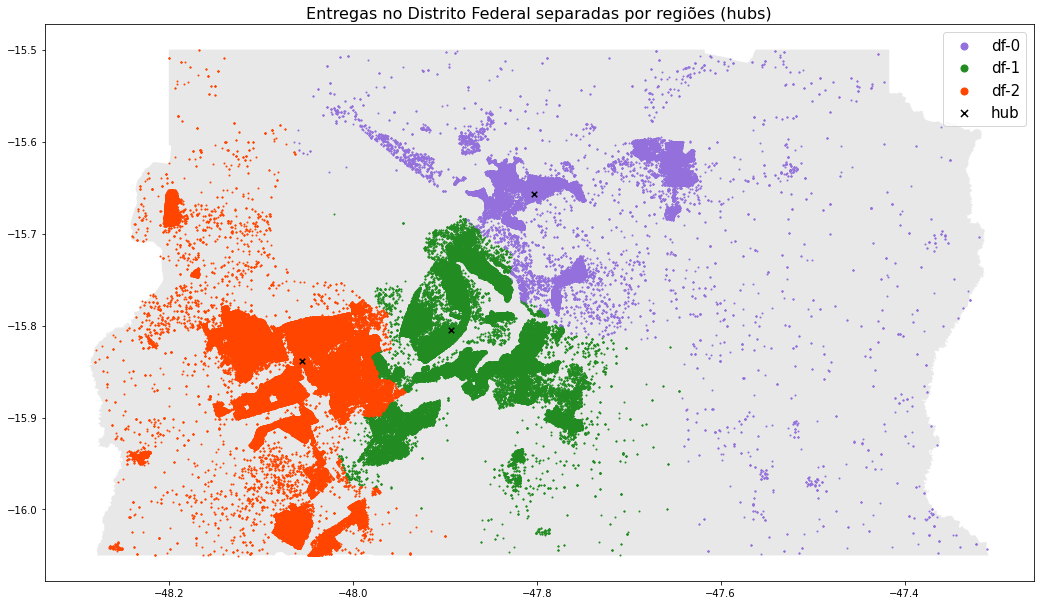

In [ ]:
#vamos começar plotando uma imagem vazia, depois colocamos o mapa do DF, depois as entregas e por fim os hubs

fig, ax = plt.subplots(figsize=(45/2.54, 45/2.54))

#inserindo o mapa do DF
mapa.plot(ax=ax, alpha=0.5, color='lightgrey')

#plotando as entregas por região
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color='mediumpurple', label='df-0')
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color='forestgreen', label='df-1')
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color='orangered', label='df-2')

#plotando a localização dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker='x', color='black', label='hub')

#edição de legenda

plt.title('Entregas no Distrito Federal separadas por regiões (hubs)', fontdict={'fontsize':16})
lgnd = plt.legend(prop={'size': 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

**Insights:**

**1.** De acordo com a visualização das entregas por região, podemos observar que os três **hubs** (centros de distribuição regional) estão bem localizados no que diz respeito a trajetória das entregas;

**2.** A região **df-2** que compreende aproximadamente Taguatinga, Ceilândia e Samambaia, possui uma grande concentração de entregas, confirmando os dados populacionais da região, que indicam Ceilândia e Taguatinga como as regiões com maior densidade demográfica do Distrito Federal (segundo dados do IBGE);

**3.** A região central **df-1** que corresponde a Brasília, Guará, Cruzeiro e Lago Sul possui quase todas as entregas concentradas ao redor do hub, sendo observados pouquíssimas entregas mais distantes e espaçadas. Esses dados corroboram com o fato de que esta região tem a segunda maior densidade demográfica do Distrito Federal, tendo Brasília como o grande centro urbano;

**4.** A região **df-0** que compreende Sobradinho, Planaltina e São Sebastião, tem a menor quantidade concentrada de entregas das três regiões visualizadas, e possui uma grande parte das entregas distantes geográficamente e bem espaçadas. Esta região tem a menor taxa de população urbana das três regiões.

**8.2 Gráfico de entrega por região**

Vamos construir um gráfico de barras com o percentual de entregas por região, mas antes, vamos selecionar as informações de interesse em um dataframe com o método *Normalize*, que faz uma contagem relativa de proporção, resultando em uma porcentagem.

In [ ]:
grafico = pd.DataFrame(loggi_df[['region', 'vehicle_capacity']]. value_counts(normalize=True)).reset_index()
grafico.rename(columns={0:'region_percent'}, inplace=True)
grafico.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


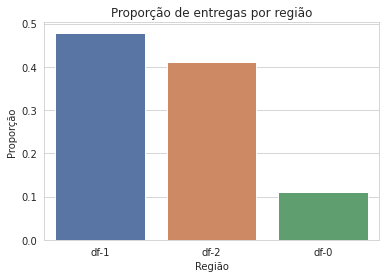

In [ ]:
#construindo o gráfico de barras

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=grafico, x='region', y='region_percent', ci=None, palette='deep')
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

In [ ]:
#calculo da mediana do tamanho das entregas por região

grafico_suburb = pd.DataFrame(loggi_df[['region', 'delivery_size']].groupby('region').agg('median'))
grafico_suburb.head()

,delivery_size
region,
df-0,5.0
df-1,6.0
df-2,6.0


**Insights:**

**1.** As regiões **df-1** e **df-2** possuem respectivamente, as **maiores** proporções na quantidade de entregas realizadas, totalizando aproximadamente 88% do total;

**2.** A região **df-0** possui aproximadamente 11% do total de entregas realizadas;

**3.** A partir do cálculo da mediana do tamanho dos pacotes entregues em cada região, podemos concluir que a **região df-0**, além de ter as entregas mais distantes geograficamente umas das outras e a menor porcentagem na quantidade de entregas, também possui pacotes de menores tamanhos.

**10. Conclusão**

A partir dos análises feitas acima, podemos fazer algumas considerações e sugestões a respeito da logística de entregas feita pela Loggi no Distrito Federal. Como a região df-0 possui uma menor quantidade de entregas (11% do total) e pacotes menores em relação as outra regiões, talvez fosse de interesse da empresa realocar veículos de entrega da região df-0 para as outras duas regiões, que tem maiores demandas em relação a quantidade de entregas e tamanho dos pacotes.